# Image coding fundamentals

### Motivation

In [1]:
!wget http://www.hpca.ual.es/~vruiz/images/Homer.png

--2017-10-21 08:02:43--  http://www.hpca.ual.es/~vruiz/images/Homer.png
Resolving www.hpca.ual.es... 150.214.150.42, 150.214.150.42
Connecting to www.hpca.ual.es|150.214.150.42|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374512 (366K) [image/png]
Saving to: ‘Homer.png’

Homer.png           100%[===================>] 365.73K  2.16MB/s    in 0.2s    

2017-10-21 08:02:44 (2.16 MB/s) - ‘Homer.png’ saved [374512/374512]



![Homer.png](./Homer.png)

In [2]:
!echo `wc -c < Homer.png` bytes

374512 bytes


In [3]:
!convert -quality 40 Homer.png Homer.jp2
# Note: in OSX, install imagemagick with: "brew install imagemagick --with-openjpeg"

![Homer.jp2](./Homer.jp2)

In [4]:
!echo `wc -c < Homer.jp2` bytes

390736 bytes


In [5]:
from PIL import Image, ImageChops, ImageOps
orig = Image.open('Homer.png')
comp = Image.open('Homer.jp2')
diff = ImageChops.subtract(orig, comp)
diff = ImageOps.equalize(diff)
diff.save('diff.png')

ModuleNotFoundError: No module named 'PIL'

![diff.png](./diff.png)

## Spatial redundancy

Image compressors exploit *spatial redundancy* to achieve better bit-rate/distortion ratios.

In [ ]:
%cd 00-fundamentals/
!wget http://www.hpca.ual.es/~vruiz/images/lena.png
!convert lena.png lena.ppm
!pnmcut -top 250 -right 350 -width 40 -height 40 < lena.ppm | pnmtopng > lena-cut.png
!fig2dev -L png -m 4 correlacion_lena.fig > correlacion_lena.png
%cd ..

<img src="00-fundamentals/correlacion_lena.png" style="width: 800px;"/>

Spatial redundancy generates that neighbor pixels have similar colors.

## Luminance and chrominance

[Chrominance](https://en.wikipedia.org/wiki/Chrominance) (or chroma) is the signal used in video systems to convey the color information of the picture or a video. It was defined to add the color signal to the black and white one. Thus, the same signal, composed by two different subsignals: Y and UV that can be isolated by filtering, was compatible with both, black and white (which only used Y) and color ones (that used YUV).

Later, in digital video, the YUV color domain was called the [YCrCb color domain](https://en.wikipedia.org/wiki/YCbCr).

## Spectral (color) redundancy

$\text{RGB}$ domain is more redundant than the [$\text{Y'UV}$ domain](https://en.wikipedia.org/wiki/YUV):

\begin{equation}
    \left(
      \begin{array}{c}
        \text{Y'}\\
        \text{U}\\
        \text{V}
      \end{array}
    \right) =
    \left(
      \begin{array}{rrr}
          0,299 & 0,587 & 0,144 \\
          -0.14713 & -0.28886 &  0.436 \\
          0.615   & -0.51499 & -0.10001
      \end{array}
    \right)
    \left(
      \begin{array}{c}
        \text{R}\\
        \text{G}\\
        \text{B}
      \end{array}
    \right)
\end{equation}

\begin{equation}
    \left(
      \begin{array}{c}
        \text{R}\\
        \text{G}\\
        \text{B}
      \end{array}
    \right) =
    \left(
      \begin{array}{rrr}
          1 &  0       &  1.13983 \\
          1 & -0.39465 & -0.58060 \\
          1 &  2.03211 &  0
      \end{array}
    \right)
    \left(
      \begin{array}{c}
        \text{Y'}\\
        \text{U}\\
        \text{V}
      \end{array}
    \right)
\end{equation}

Used, for example, in [JPEG](https://en.wikipedia.org/wiki/JPEG).

In [ ]:
!wget http://www.hpca.ual.es/~vruiz/images/san-diego.png

![san-diego.png](./san-diego.png)

In [ ]:
from scipy import misc
from scipy.stats import entropy
import numpy as np

In [ ]:
RGB = misc.imread('san-diego.png')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,16))
plt.imshow(RGB)
plt.show()

In [ ]:
R = RGB.copy()
R[:,:,1] = 0
R[:,:,2] = 0
G = RGB.copy()
G[:,:,0] = 0
G[:,:,2] = 0
B = RGB.copy()
B[:,:,0] = 0
B[:,:,1] = 0

In [ ]:
fig = plt.figure(figsize=(24,16))

a = fig.add_subplot(1,3,1) # Rows, cols, subfigure
R_histo = np.histogram(RGB[:,:,0], bins=256)[0]
R_entropy = entropy(R_histo, base=2)
a.set_title("entropy(R) = " + str(R_entropy))
imgplot = plt.imshow(R)

a = fig.add_subplot(1,3,2)
G_histo = np.histogram(RGB[:,:,1], bins=256)[0]
G_entropy = entropy(G_histo, base=2)
a.set_title("entropy(G) = " + str(G_entropy))
imgplot = plt.imshow(G)

a = fig.add_subplot(1,3,3)
B_histo = np.histogram(RGB[:,:,2], bins=256)[0]
B_entropy = entropy(B_histo, base=2)
a.set_title("entropy(B) = " + str(B_entropy))
imgplot = plt.imshow(B)
plt.show()

# See https://stackoverflow.com/questions/3584805/in-matplotlib-what-does-the-argument-mean-in-fig-add-subplot111

In [ ]:
print('Total entropy = {}'.format(R_entropy + G_entropy + B_entropy))

In [ ]:
import cv2
components = ('r','g','b')
histr = [None for col in components]
for i,com in enumerate(components):
    histr[i] = cv2.calcHist([RGB],[i],None,[256],[0,256])
    plt.plot(histr[i], color = com)
plt.xlim([0,256])
plt.show()

In [ ]:
# https://stackoverflow.com/questions/43983265/rgb-to-yuv-conversion-and-accessing-y-u-and-v-channels
import cv2
import numpy as np

In [ ]:
def make_lut_u():
    return np.array([[[i,255-i,0] for i in range(256)]],dtype=np.uint8)

def make_lut_v():
    return np.array([[[0,255-i,i] for i in range(256)]],dtype=np.uint8)

In [ ]:
lut_U, lut_V = make_lut_u(), make_lut_v()

In [ ]:
YUV = cv2.cvtColor(RGB, cv2.COLOR_RGB2YUV)

In [ ]:
Y, U, V = cv2.split(YUV)

In [ ]:
Y = cv2.cvtColor(Y, cv2.COLOR_GRAY2BGR)
U = cv2.cvtColor(U, cv2.COLOR_GRAY2BGR)
V = cv2.cvtColor(V, cv2.COLOR_GRAY2BGR)

In [ ]:
U_mapped = cv2.LUT(U, lut_U)
V_mapped = cv2.LUT(V, lut_V)

In [ ]:
fig = plt.figure(figsize=(24,16))

a = fig.add_subplot(1,3,1) # Rows, cols, subfigure
Y_histo = np.histogram(Y, bins=256)[0]
Y_entropy = entropy(Y_histo, base=2)
a.set_title("entropy(Y') = " + str(Y_entropy))
imgplot = plt.imshow(Y)

a = fig.add_subplot(1,3,2)
U_histo = np.histogram(U, bins=256)[0]
U_entropy = entropy(U_histo, base=2)
a.set_title("entropy(U) = " + str(U_entropy))
imgplot = plt.imshow(U_mapped)

a = fig.add_subplot(1,3,3)
V_histo = np.histogram(V, bins=256)[0]
V_entropy = entropy(V_histo, base=2)
a.set_title("entropy(V) = " + str(V_entropy))
imgplot = plt.imshow(V_mapped)

plt.show()

In [ ]:
print('Total entropy = {}'.format(Y_entropy + U_entropy + V_entropy))

In [ ]:
histr = [None for com in components]
for i,com in enumerate(components):
    histr[i] = cv2.calcHist([YUV],[i],None,[256],[0,256])
    plt.plot(histr[i], color = com)
plt.xlim([0,256])
plt.show()

## Chrominance subsampling

[The human visual system is more sensitive to the luma (Y’) than to the chroma (UV)](https://en.wikipedia.org/wiki/Chroma_subsampling). This means than the chroma can be subsampled without a signiﬁcant loss of quality in the images.

In [ ]:
%cd 00-fundamentals/
!fig2dev -L svg -m 4 color_subsampling.fig > color_subsampling.svg
%cd ..

<img src="00-fundamentals/color_subsampling.svg" style="width: 800px;"/>

In [ ]:
import pywt

In [ ]:
def subsample_chroma(image, levels):
    subsampled = np.ndarray((image.shape[0], image.shape[1], 3), 'uint8')
    
    # Luma
    subsampled[:,:,0] = image[:,:,0]

    # Chroma Cb
    DWT_coeffs = pywt.wavedec2(image[:,:,1], 'bior3.5', level=levels)
    for i in range(levels-1):
        DWT_coeffs[i+1][0][:,:] = 0.0 # LH subband
        DWT_coeffs[i+1][1][:,:] = 0.0 # HL subband
        DWT_coeffs[i+1][2][:,:] = 0.0 # HH subband

    subsampled[:,:,1] = pywt.waverec2(DWT_coeffs, 'bior3.5')
                  
    # Chroma Cb
    DWT_coeffs = pywt.wavedec2(image[:,:,2], 'bior3.5', level=levels)
    for i in range(levels-1):
        DWT_coeffs[i+1][0][:,:] = 0.0 # LH subband
        DWT_coeffs[i+1][1][:,:] = 0.0 # HL subband
        DWT_coeffs[i+1][2][:,:] = 0.0 # HH subband
    subsampled[:,:,2] = pywt.waverec2(DWT_coeffs, 'bior3.5')

    return (subsampled, (subsampled.shape[0], subsampled.shape[1]), DWT_coeffs[0].shape)

In [ ]:
chroma_subsampled_YUV, luma_shape, chroma_shape = subsample_chroma(YUV, 5)
print("Luma shape =", luma_shape, "\nChroma shape =", chroma_shape)

In [ ]:
fig = plt.figure(figsize=(24,16))

a = fig.add_subplot(1,3,1) # Rows, cols, subfigure
a.set_title("Y")
imgplot = plt.imshow(chroma_subsampled_YUV[:,:,0], cmap='gray')

a = fig.add_subplot(1,3,2)
a.set_title("U")
imgplot = plt.imshow(chroma_subsampled_YUV[:,:,1], cmap='gray')

a = fig.add_subplot(1,3,3)
a.set_title("V")
imgplot = plt.imshow(chroma_subsampled_YUV[:,:,2], cmap='gray')

plt.show()
#plt.imshow(chroma_subsampled_YUV[:,:,1], cmap='gray' # Shows U
#plt.show()

In [ ]:
chroma_subsampled_RGB = cv2.cvtColor(chroma_subsampled_YUV, cv2.COLOR_YUV2RGB)

In [ ]:
fig = plt.figure(figsize=(24,16))

a = fig.add_subplot(1,2,1) # Rows, cols, subfigure
plt.imshow(RGB)

a = fig.add_subplot(1,2,2) # Rows, cols, subfigure
plt.imshow(chroma_subsampled_RGB)

plt.show()

In [ ]:
print("The subsampled image uses", \
      luma_shape[0]*luma_shape[1] +
      chroma_shape[0]*chroma_shape[1] * 2,
      "bytes"
     )
print("The original image uses", \
      luma_shape[0]*luma_shape[1] * 3,
      "bytes"
     )

## DCT (Discrete Cosine Transform)

### Definition

Forward (direct) transform:

\begin{equation}
  \text{DCT}[u] = \frac{\sqrt{2}}{\sqrt{N}}
  K(u)\sum_{n=0}^{N-1} s[n]\cos\frac{(2n+1)\pi u}{2n},
\end{equation}

backward (inverse) transform:

\begin{equation}
  s[n] = \frac{\sqrt{2}}{\sqrt{N}}
  \sum_{u=0}^{N-1} K(u)\text{DCT}[u]\cos\frac{(2n+1)\pi u}{2n},
\end{equation}

where $N$ is the number of pixels, and $s[n]$ denotes the $n$-th pixel
of the image $s$, and

\begin{equation}
  K(u) =
  \left\{
    \begin{array}{ll}
      \frac{1}{\sqrt{2}} & \text{si}~u=0\\
      1 & \text{if}~u>0.
    \end{array}
    \right.
\end{equation}

### Properties

1. **Separable**: the $D$-dimensional DCT can be computed using the $1$D DCT in each possible dimension.
2. In general, **high energy compaction**: a small number of DCT coefficients can reconstruct with a reasonable accuracy the original signal.
3. **Unitary**: the energy of the DCT coefficients is proportional to the energy of the samples.
4. **Orthonormality**: DCT basis are orthonormal (orthogonal + unitary) and therefore, DCT coefficients are uncorrelated.

In [ ]:
# Load lena

import urllib.request
from matplotlib import pyplot as plt
import numpy as np
import cv2

%matplotlib inline
HTTP_response = urllib.request.urlopen('http://www.hpca.ual.es/~vruiz/images/lena.png')
arr = np.asarray(bytearray(HTTP_response.read()), dtype=np.uint8)
BRG = cv2.imdecode(arr,-1)
RGB = cv2.cvtColor(BRG, cv2.COLOR_BGR2RGB)
plt.imshow(RGB)

In [ ]:
from scipy import fftpack
from PIL import Image

# Forward and backward DCT wrappers

def forward_2d_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def inverse_2d_dct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

In [ ]:
# Color 2D-DCT is the 2D-DCT of each component
components = ('r','g','b')
dct = [None]*3
for i,com in enumerate(components):
    print("{} ".format(i), end='')
    dct[i] = forward_2d_dct(RGB[:,:,i])

In [ ]:
# View DCT coefs
view_dct = np.empty(RGB.shape)
for i,com in enumerate(components):
    view_dct[:,:,i] = dct[i][:,:]
plt.imshow((view_dct - view_dct.min())/(view_dct.max() - view_dct.min())*255)

In [ ]:
# Reconstruct with biggest DCT coefs
N = 100 # Step size (in coeffs) for each reconstruction
for k in range(32): # Up to 32 reconstructions
    
    coeffs_indexes = np.empty((RGB.shape[0] * RGB.shape[1]), dtype='float, int, int')
    for i in range(RGB.shape[0]):
        for j in range(RGB.shape[1]):
            coeffs_indexes[i*RGB.shape[1]+j] = (np.abs(dct[0][i][j]), i, j)
            
    sorted = np.sort(coeffs_indexes, axis = -1)[::-1]
    
    x_coords = np.empty((k+1)*N, dtype='int')
    y_coords = np.empty((k+1)*N, dtype='int')
    for kk in range((k+1)*N):
        x_coords[kk] = sorted[kk][1]
        y_coords[kk] = sorted[kk][2]

    recons = np.empty(RGB.shape)
    
    dct_copy = np.zeros(dct[0].shape)

    dct_copy[x_coords, y_coords] = dct[0][x_coords, y_coords]
    recons_ = inverse_2d_dct(dct_copy)
    recons[:,:,0] = recons_[:,:].clip(0,255)
    
    dct_copy = np.empty_like(dct[1])
    dct_copy[x_coords, y_coords] = dct[1][x_coords, y_coords]
    recons_ = inverse_2d_dct(dct_copy)
    recons[:,:,1] = recons_[:,:].clip(0,255)

    dct_copy = np.empty_like(dct[2])
    dct_copy[x_coords, y_coords] = dct[2][x_coords, y_coords]
    recons_ = inverse_2d_dct(dct_copy)
    recons[:,:,2] = recons_[:,:].clip(0,255)
    
    plt.imshow(recons.astype('uint8'))
    plt.grid(False);
    plt.xticks([]);
    plt.yticks([]);
    print("{} coefficients".format((k+1)*N), end='')
    plt.show()


## $8\times 8$ DCT

DCT exhibits a bad performance when applied to high resolution images, but locally it works pretty well. For this reason, most DCT-based image/video codecs divide the images in blocks (typically of 8x8 pixels) and apply the DCT to each block, independently. Let's see the basis functions (the synthesys filters) of the 2D-DCT.

In [ ]:
fig = plt.figure(figsize=(16, 16))
for i in range(8):
    for j in range(8):
        dct_copy = np.zeros((8, 8))

        dct_copy[i][j] = 1.0
        recons = inverse_2d_dct(dct_copy)
        
        max = recons.max()
        min = recons.min()
        if(max!=min):
            recons = (recons-min)/(max-min)*255

        plt.subplot(8, 8, 8*i+j+1)
        plt.imshow(recons, cmap=plt.cm.gray)
        plt.grid(False);
        plt.xticks([]);
        plt.yticks([]);

## Dyadic DWT (Discrete Wavelet Transform)

Key features:

1. **High spectral compaction**.
2. **Multiresolution representation**: it is easy to recover a reduced version of the original image if only a sub-set of the coeﬃcients is proccesed.

### Filters bank implementation

<img src="00-fundamentals/QMF.svg" style="width: 800px;"/>

Where:
\begin{equation}
  S = (\uparrow^2(L)*s_L) + (\uparrow^2(H)*s_H)
\end{equation}
and
\begin{equation}
  \begin{array}{rcl}
    L & = & \downarrow^2(S*a_L) \\
    H & = & \downarrow^2(S*a_H).
  \end{array}
\end{equation}


Comments:

1. $a_L$ and $a_H$ are the transfer function (the transfer function of a filter is the response of that filter to the unitary impulse function (Dirac's delta))  of a low-pass filter and high-pass filter, respectively, that have been designed to be complementary (ideally, in $L$ we only found the frequencies of $S$ that are not in $H$, and viceversa). When this is true, it is said the we are using a Perfect Reconstruction Quadrature Mirror Filter bank and the DWT is biorthogonal.

2. In the wavelet theory, $s_L$ is named the *scale function* and $s_H$ the *mother function* or *wavelet basis function*. The coefficients of $L$ are also knwon as the *scale coeffients* and the coeffcientes of $H$ the *wavelet coefficients* [[Sovic & Sersic, 2012]](https://scholar.google.es/scholar?hl=en&as_sdt=0%2C5&q=Ana+Sovic+and+Damir+Sersic.+Signal+decomposition+methods+for+reducind+drawbacks+of+the+dwt&btnG=).

3. $\downarrow^2(\cdot)$ and $\uparrow^2(\cdot)$ donote the
  subsampling and oversampling operations:
  
  \begin{equation}
    (\downarrow^2(S))_i = S_{2i}
  \end{equation}
  
  and
  
  \begin{equation}
    (\uparrow^2(S))_i =
  \left\{
  \begin{array}{ll}
    S_{i/2} & \text{if $i$ if even} \\
    0 & \text{otherwise}.
  \end{array}
  \right.
  \end{equation}
  
  where $S_i$ if the $i$-th sample of $S$.
  
4. $*$ is the convolution operator.

5. Notice that half of the filtered samples are wasted.

### Lifting implementation [[Sweldens & Schröder, 2000)]](https://scholar.google.es/scholar?hl=es&as_sdt=0%2C5&q=building+wavelets+at+home&btnG=)

<img src="00-fundamentals/lifting.svg" style="width: 800px;"/>

Comments:

1.
\begin{equation}
  H_i = S_{2i+1} - {\cal P}(\{S_{2i}\})_i
  \tag{PredictionStep}
  \label{eq:PredictionStep}
\end{equation}

\begin{equation}
  L_i = S_{2i} + \{{\cal U}(H)\}_i
  \tag{UpdateStep}
  \label{eq:UpdateStep}
\end{equation}

2. Subsampled signals $\{S_{2i}\}$ and $\{S_{2i+1}\}$ can been computed by using

\begin{equation*}
   \{S_{2i+1}\} = \downarrow^2(Z^{-1}(S))
\end{equation*}

and

\begin{equation*}
   \{S_{2i}\} = \downarrow^2(S),
\end{equation*}

where $Z^{-1}$ represents the one sample delay function.

3. $H$ has tipically less energy and entropy than $\{S_{2i+1}\}$.
4. $L$ has less aliasing than $\{S_{2i}\}$ (notice that $L$ has not
  been low-pass filtered before subsampling it).

## $T$-levels 1D-DWT

<img src="00-fundamentals/n_levels_dwt1d.svg" style="width: 800px;"/>

## 2D-DWT

The one-dimensional (1D) DWT is a separable transform. Therefore, the 2D DWT can be computed applying the DWT to all the rows of an image and next, to all the columns, or viceversa.

<img src="00-fundamentals/2D-DWT.svg" style="width: 800px;"/>

The contribution of a coefficient of a subband $b$ is determined by the DWT basis fuction ${s_H}^b$ asociated to that coefficient, which can be empirically determined by applying the inverse DWT to the Dirac Impulse function localized in that coefficient (notice that ${s_H}^b$ does not depend on the coefficient because we are supposing that all the coefficients of a subband have the same contribution, the same basis fuction) [[Rabbani, Joshi & Jones, 2009]](https://scholar.google.es/scholar?hl=es&as_sdt=0%2C5&q=Majid+Rabban%2C+Rajan+L.+Joshi%2C+and+Paul+W.+Jones.+The+JPEG+2000+Suite%2C+chapter+JPEG+2000+Core+Coding+System+%28Part+1%29.+WILEY%2C+2009&btnG=). Therefore, the L$_2$-norm for the subband $b$ is computed as the energy of a basis function of that subband as

\begin{equation}
  E({s_H}^b) = \sum_i{|{s_H}^b_i|}^2.
\end{equation}

In the case of the 5/3-DWT, the L$_2$-norms of the DWT subbands are:


<img src="00-fundamentals/factores_5_3_L2_norm.svg" style="width: 800px;"/>

### Haar filters [[Haar, 1910]](https://scholar.google.es/scholar?hl=es&as_sdt=0%2C5&q=A.+Haar.+Zur+Theorie+der+orthogolanen+Funktionen-Systeme.+Mathematische+Annalen%2C+69%3A331%E2%80%93371%2C+1910&btnG=)

The $i$-th sample of the low-frequency subband is computed (using a filter plus subsampling) as

\begin{equation}
  L_i=\frac{S_{2i}+S_{2i+1}}{2},
  \tag{HaarL}
  \label{eq:Haar_A-LPF}
\end{equation}

and the $i$-th sample of the high-frequency subband as

\begin{equation}
  H_i=S_{2i+1}-S_{2i}.
  \tag{HaarH}
  \label{eq:Haar_A-HPF}
\end{equation}

If Lifting is used,

\begin{equation}
  L_i=S_{2i}+\frac{H_i}{2}.
  \tag{HaarLLifted}
  \label{eq:Haar_A-LPF-lifting}
\end{equation}

Notice that $H_i=0$ if $S_{2i+1}=S_{2i}$, therefore, the Haar transform is good to encode constant signals. The notation X/Y indicates the length (taps or number of coefficients) of the low-pass and the high-pass (convolution) filters of the filter bank implementation (not Lifting), respectively.

#### 2D basis functions

In [ ]:
import pywt # pip install pywavelets
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

fig = plt.figure(figsize=(16, 16))
wavelet_= 'haar'

for i in range(4):
    for j in range(4):

        pixels = np.zeros((32, 32))
        #coeffs = pywt.wavedec2(pixels, wavelet=wavelet_, mode='per', level=3)
        coeffs = pywt.wavedec2(pixels, wavelet=wavelet_, level=3)
        #print(coeffs[0].shape)
        coeffs[0][i, j] = 1.0
#for i in range(len(coeffs)-1):
    #print(i)
    #coeffs[i+1][0][1, 1] = 1.0
    #coeffs[i+1][1][1, 1] = 1.0
    #coeffs[i+1][2][1, 1] = 1.0
        recons = pywt.waverec2(coeffs, wavelet=wavelet_)
        max = recons.max()
        min = recons.min()
        if(max!=min):
            recons = (recons-min)/(max-min)*255
            
        plt.subplot(8, 8, 8*i+j+1)
        plt.imshow(recons, cmap=plt.cm.gray)
        plt.grid(False);
        plt.xticks([]);
        plt.yticks([]);
#plt.subplot(1, 1, 1)
#plt.imshow(recons, cmap='gray')

In [ ]:
import pywt # pip install pywavelets
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

fig = plt.figure(figsize=(16, 16))
wavelet_= 'haar'

for i in range(4):
    for j in range(4):

        pixels = np.zeros((32, 32))
        coeffs = pywt.wavedec2(pixels, wavelet=wavelet_, level=3)
        coeffs[1][0][i, j] = 1.0
        recons = pywt.waverec2(coeffs, wavelet=wavelet_)
        max = recons.max()
        min = recons.min()
        if(max!=min):
            recons = (recons-min)/(max-min)*255
            
        plt.subplot(8, 8, 8*i+j+1)
        plt.imshow(recons, cmap=plt.cm.gray)
        plt.grid(False);
        plt.xticks([]);
        plt.yticks([]);

In [ ]:
import pywt # pip install pywavelets
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

fig = plt.figure(figsize=(16, 16))
wavelet_= 'haar'

for i in range(4):
    for j in range(4):

        pixels = np.zeros((32, 32))
        coeffs = pywt.wavedec2(pixels, wavelet=wavelet_, level=3)
        coeffs[1][1][i, j] = 1.0
        recons = pywt.waverec2(coeffs, wavelet=wavelet_)
        max = recons.max()
        min = recons.min()
        if(max!=min):
            recons = (recons-min)/(max-min)*255
            
        plt.subplot(8, 8, 8*i+j+1)
        plt.imshow(recons, cmap=plt.cm.gray)
        plt.grid(False);
        plt.xticks([]);
        plt.yticks([]);

In [ ]:
import pywt # pip install pywavelets
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

fig = plt.figure(figsize=(16, 16))
wavelet_= 'haar'

for i in range(4):
    for j in range(4):

        pixels = np.zeros((32, 32))
        coeffs = pywt.wavedec2(pixels, wavelet=wavelet_, level=3)
        coeffs[1][2][i, j] = 1.0
        recons = pywt.waverec2(coeffs, wavelet=wavelet_)
        max = recons.max()
        min = recons.min()
        if(max!=min):
            recons = (recons-min)/(max-min)*255
            
        plt.subplot(8, 8, 8*i+j+1)
        plt.imshow(recons, cmap=plt.cm.gray)
        plt.grid(False);
        plt.xticks([]);
        plt.yticks([]);

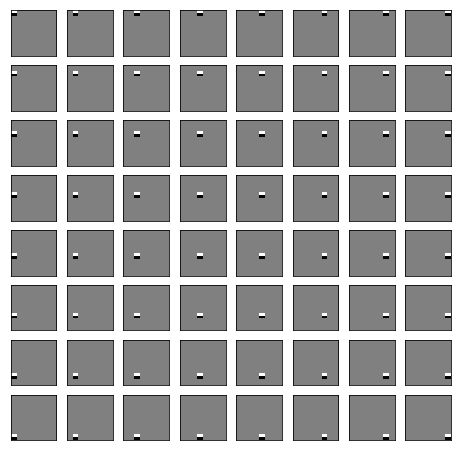

In [2]:
import pywt # pip install pywavelets
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

fig = plt.figure(figsize=(16, 16))
wavelet_= 'haar'

for i in range(8):
    for j in range(8):

        pixels = np.zeros((32, 32))
        coeffs = pywt.wavedec2(pixels, wavelet=wavelet_, level=3)
        coeffs[2][0][i, j] = 1.0
        recons = pywt.waverec2(coeffs, wavelet=wavelet_)
        max = recons.max()
        min = recons.min()
        if(max!=min):
            recons = (recons-min)/(max-min)*255
            
        plt.subplot(16, 16, 16*i+j+1)
        plt.imshow(recons, cmap=plt.cm.gray)
        plt.grid(False);
        plt.xticks([]);
        plt.yticks([]);

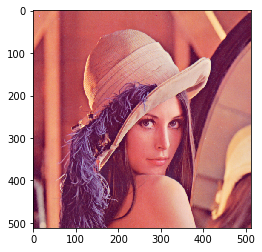

In [132]:
# Load lena

import urllib.request
from matplotlib import pyplot as plt
import numpy as np
import cv2 # pip install opencv-python

%matplotlib inline
HTTP_response = urllib.request.urlopen('http://www.hpca.ual.es/~vruiz/images/lena.png')
arr = np.asarray(bytearray(HTTP_response.read()), dtype=np.uint8)
BRG = cv2.imdecode(arr,-1)
pixels = cv2.cvtColor(BRG, cv2.COLOR_BGR2RGB)
plt.imshow(pixels)

In [133]:
# Color 2D-DWT is the 2D-DWT of each component
components = ('r','g','b')
coeffs = [None]*3
wavelet_= 'haar'
levels_ = 5
for i,com in enumerate(components):
    print("{} ".format(i), end='')
    coeffs[i] = pywt.wavedec2(pixels[:,:,i], wavelet=wavelet_, level=levels_)

0 1 2 

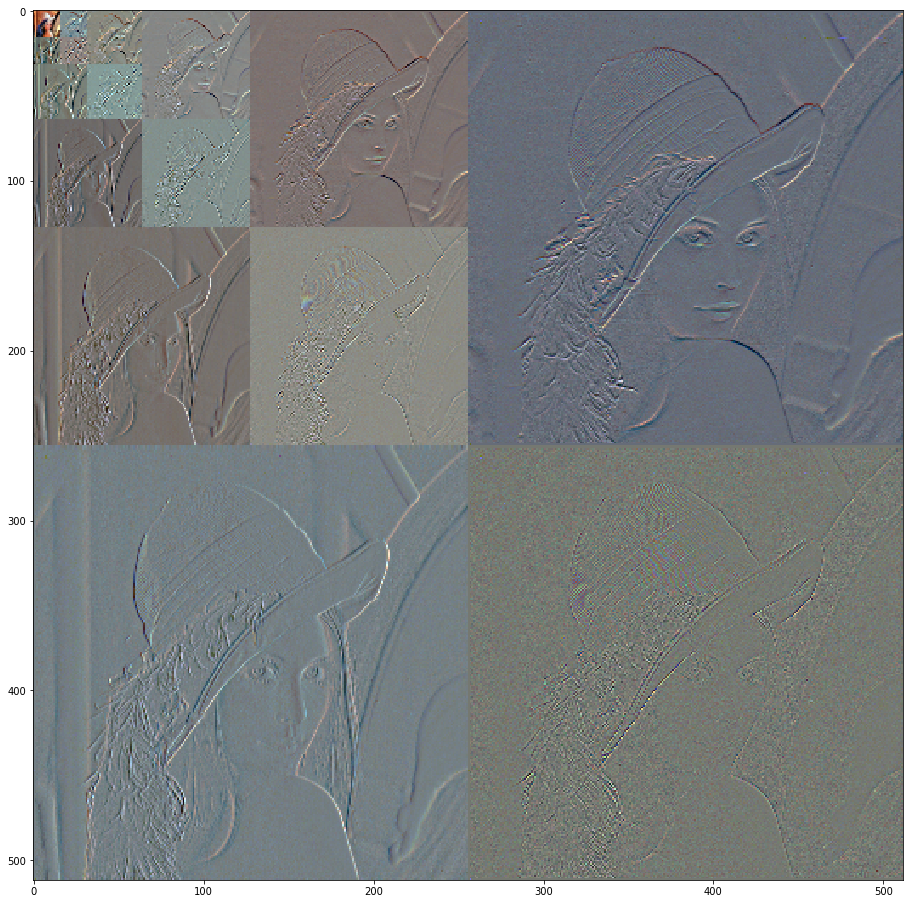

In [134]:
# View DWT coefs

fig = plt.figure(figsize=(16, 16))

view = np.empty(pixels.shape, 'uint8')

# LL subband
for i,com in enumerate(components):
    x = coeffs[i][0][:,:]
    y = ((x - x.min()) / (x.max() - x.min())*255).astype('uint8')
    view[0:coeffs[i][0].shape[0],
         0:coeffs[i][0].shape[1],
         i] = y

for l in range(levels_):

    # LH
    for i,com in enumerate(components):
        x = coeffs[i][l+1][0][:,:]
        y = ((x - x.min()) / (x.max() - x.min())*255).astype('uint8')
        view[0:coeffs[i][l+1][0].shape[0],
             coeffs[i][l+1][0].shape[1]:coeffs[i][l+1][0].shape[1]*2,
             i] = y

    # HH
    for i,com in enumerate(components):
        x = coeffs[i][l+1][1][:,:]
        y = ((x - x.min()) / (x.max() - x.min())*255).astype('uint8')
        view[coeffs[i][l+1][1].shape[0]:coeffs[i][l+1][1].shape[0]*2,
             0:coeffs[i][l+1][1].shape[1],
             i] = y

    # HH
    for i,com in enumerate(components):
        x = coeffs[i][l+1][2][:,:]
        y = ((x - x.min()) / (x.max() - x.min())*255).astype('uint8')
        view[coeffs[i][l+1][2].shape[0]:coeffs[i][l+1][2].shape[0]*2,
             coeffs[i][l+1][2].shape[1]:coeffs[i][l+1][2].shape[1]*2,
             i] = y

plt.subplot(1, 1, 1)
plt.imshow(view)

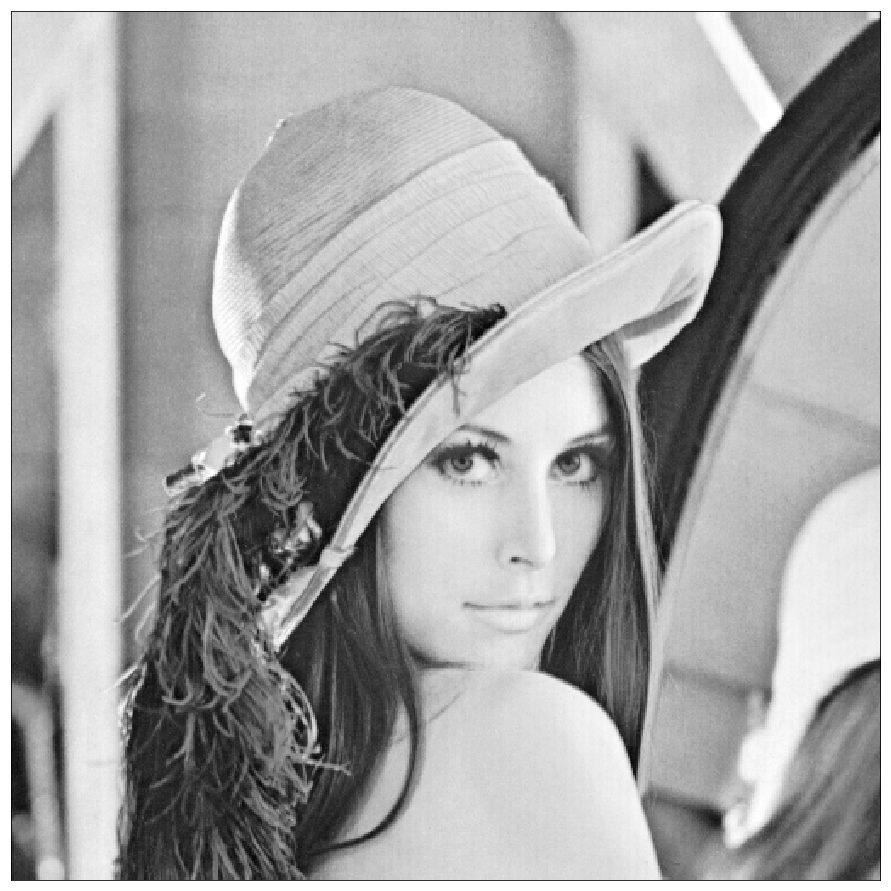

In [135]:
recons_ = pywt.waverec2(coeffs[0], wavelet=wavelet_)
max = recons_.max()
min = recons_.min()
if(max!=min):
    recons = (recons_-min)/(max-min)*255

# Visualize
fig = plt.figure(figsize=(16, 16))

plt.imshow(recons, cmap=plt.cm.gray)
plt.grid(False);
plt.xticks([]);
plt.yticks([]);
plt.show()

255 0


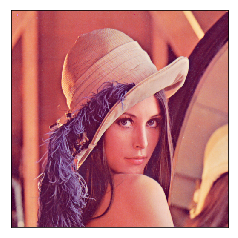

In [136]:
recons = np.empty(pixels.shape)

recons[:,:,0] = pywt.waverec2(coeffs[0], wavelet=wavelet_)
recons[:,:,1] = pywt.waverec2(coeffs[1], wavelet=wavelet_)
recons[:,:,2] = pywt.waverec2(coeffs[2], wavelet=wavelet_)
max = recons.max()
min = recons.min()
if(max!=min):
    recons = ((recons-min)/(max-min)*255).astype('uint8')
                      
# Visualize
print(recons.max(), recons.min())
plt.imshow(recons)
plt.grid(False);
plt.xticks([]);
plt.yticks([]);
plt.show()

### Progressive transmission

100 coefficients

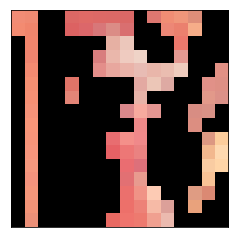

200 coefficients

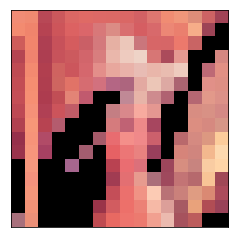

300 coefficients

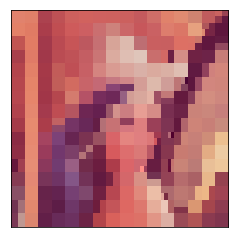

400 coefficients

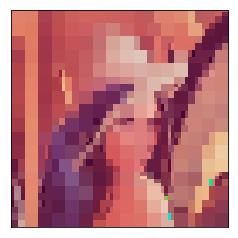

500 coefficients

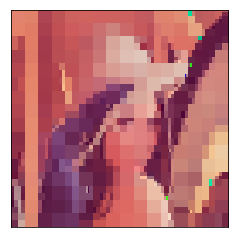

600 coefficients

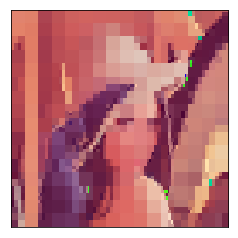

700 coefficients

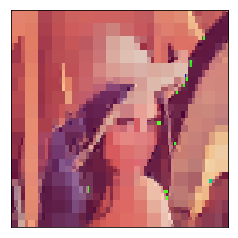

800 coefficients

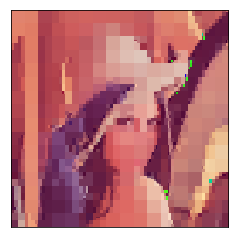

900 coefficients

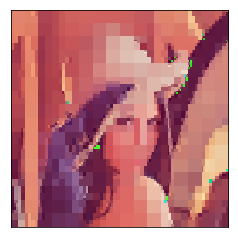

1000 coefficients

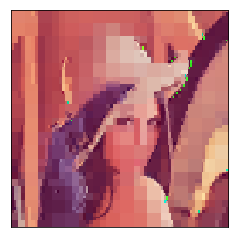

In [143]:
# Reconstruct with biggest DWT coefs
recons = np.empty(pixels.shape)

N = 100 # Step size (in coeffs) for each reconstruction
for k in range(10): # Up to 32 reconstructions

    coeffs_indexes = np.empty((pixels.shape[0] * pixels.shape[1]),
                            dtype='float, int, int, int, int')
                            # Coeff, level, subband, coor_x, coor_y

    # Process only the R component to find the higher coeffs
    
    offset = 0
    
    # LL
    for x in range(coeffs[0][0].shape[0]):
        for y in range(coeffs[0][0].shape[1]):
            coeffs_indexes[offset] = (np.abs(coeffs[0][0][x][y]), 0, 0, x, y)
            offset += 1
    
    # Rest of subbands
    for l in range(levels_):
        for s in range(3):
            for x in range(coeffs[0][l+1][s].shape[0]):
                for y in range(coeffs[0][l+1][s].shape[1]):
                    coeffs_indexes[offset] = (np.abs(coeffs[0][l+1][s][x][y]), (l+1), s, x, y)
                    offset += 1

    sorted = np.zeros((pixels.shape[0] * pixels.shape[1]), dtype='float, int, int, int, int')
    sorted = np.sort(coeffs_indexes)[::-1]

    # Reconstruct R

    # An "empty" transformed structure

    zeros = np.zeros((pixels.shape[0], pixels.shape[1]))
    filtered_coeffs = pywt.wavedec2(zeros, wavelet=wavelet_, level=levels_)

    # Copy some coeffs
    for kk in range((k+1)*N):
        if sorted[kk][1] == 0:
            filtered_coeffs[0][sorted[kk][3], sorted[kk][4]] = \
            coeffs[0][0][sorted[kk][3], sorted[kk][4]]
        else:
            #print(kk, sorted[kk][1], sorted[kk][2], sorted[kk][3], sorted[kk][4])
            filtered_coeffs[sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]] = \
            coeffs[0][sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]]
        
    recons_ = pywt.waverec2(filtered_coeffs, wavelet=wavelet_)
    recons[:,:,0] = recons_

    # Reconstruct G

    # An "empty" transformed structure

    zeros = np.zeros((pixels.shape[0], pixels.shape[1]))
    filtered_coeffs = pywt.wavedec2(zeros, wavelet=wavelet_, level=levels_)

    # Copy some coeffs
    for kk in range((k+1)*N):
        if sorted[kk][1] == 0:
            filtered_coeffs[0][sorted[kk][3], sorted[kk][4]] = \
            coeffs[1][0][sorted[kk][3], sorted[kk][4]]
        else:
            filtered_coeffs[sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]] = \
            coeffs[1][sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]]
        
    recons_ = pywt.waverec2(filtered_coeffs, wavelet=wavelet_)
    recons[:,:,1] = recons_
    
    # Reconstruct B

    # An "empty" transformed structure
    zeros = np.zeros((pixels.shape[0], pixels.shape[1]))
    filtered_coeffs = pywt.wavedec2(zeros, wavelet=wavelet_, level=levels_)

    # Copy some coeffs
    for kk in range((k+1)*N):
        if sorted[kk][1] == 0:
            filtered_coeffs[0][sorted[kk][3], sorted[kk][4]] = \
            coeffs[2][0][sorted[kk][3], sorted[kk][4]]
        else:
            filtered_coeffs[sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]] = \
            coeffs[2][sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]]

    recons_ = pywt.waverec2(filtered_coeffs, wavelet=wavelet_)
    recons[:,:,2] = recons_
                      
    max = recons.max()
    min = recons.min()
    if(max!=min):
        recons = ((recons-min)/(max-min)*255).astype('uint8')

    # Visualize
    plt.imshow(recons)
    plt.grid(False);
    plt.xticks([]);
    plt.yticks([]);
    print("{} coefficients".format((k+1)*N), end='')
    plt.show()

### 5/3 (linear) filters [[Sweldens & Schröder, 2000]](https://scholar.google.es/scholar?hl=es&as_sdt=0%2C5&q=building+wavelets+at+home&btnG==)

The $i$-th sample of the low-frequency subband (using a filter-bank implementation) is

\begin{equation}
  L_i=-\frac{1}{8}S_{2i-2}+\frac{1}{4}S_{2i-1}+\frac{3}{4}S_{2i}
  +\frac{1}{4}S_{2i+1}-\frac{1}{8}S_{2i+2}
  \tag{5/3L}
  \label{eq:Lineal_A-LPF}
\end{equation}

and the $i$-th sample of the high-frequency signal is computed by

\begin{equation}
  H_i=S_{2i+1}-\frac{S_{2i}+S_{2i+2}}{2},
  \tag{5/3H}
  \label{eq:Lineal_A-HPF}

that, if we use Lifting, it can be also computed using less operations by

\begin{equation}
  L_i=S_{2i}+\frac{H_{i-1}+H_i}{4}.
  \tag{5/3LLifted}
  \label{eq:Lineal_A-LPF_lifting}
\end{equation}

Notice that $H_i=0$ if $S_{2i+1}=(S_{2i}+S_{2i+2})/2$. Therefore, the 5/3 transform is suitable to encode lineally piece-wised signals.

#### 2D basis functions

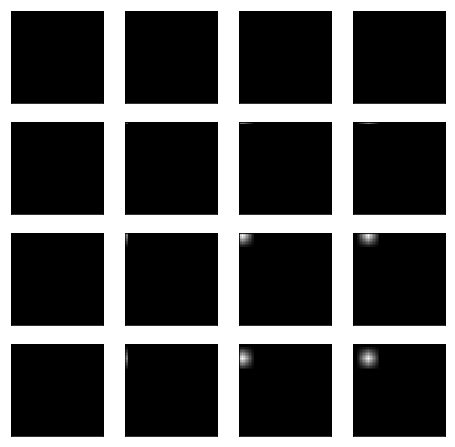

In [6]:
import pywt # pip install pywavelets
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

fig = plt.figure(figsize=(16, 16))
wavelet_= 'bior2.2'

for i in range(4):
    for j in range(4):

        pixels = np.zeros((64, 64))
        #coeffs = pywt.wavedec2(pixels, wavelet=wavelet_, mode='per', level=3)
        coeffs = pywt.wavedec2(pixels, wavelet=wavelet_, level=3)
        #print(coeffs[0].shape)
        coeffs[0][i, j] = 1.0
#for i in range(len(coeffs)-1):
    #print(i)
    #coeffs[i+1][0][1, 1] = 1.0
    #coeffs[i+1][1][1, 1] = 1.0
    #coeffs[i+1][2][1, 1] = 1.0
        recons = pywt.waverec2(coeffs, wavelet=wavelet_)
        max = recons.max()
        min = recons.min()
        if(max!=min):
            recons = (recons-min)/(max-min)*255
            
        plt.subplot(8, 8, 8*i+j+1)
        plt.imshow(recons, cmap=plt.cm.gray)
        plt.grid(False);
        plt.xticks([]);
        plt.yticks([]);
#plt.subplot(1, 1, 1)
#plt.imshow(recons, cmap='gray')

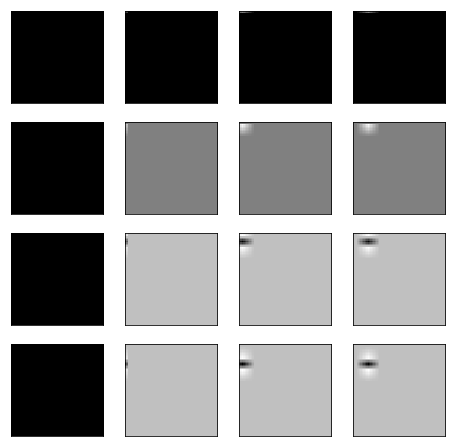

In [8]:
fig = plt.figure(figsize=(16, 16))

for i in range(4):
    for j in range(4):

        pixels = np.zeros((64, 64))
        coeffs = pywt.wavedec2(pixels, wavelet=wavelet_, level=3)
        coeffs[1][0][i, j] = 1.0
        recons = pywt.waverec2(coeffs, wavelet=wavelet_)
        max = recons.max()
        min = recons.min()
        if(max!=min):
            recons = (recons-min)/(max-min)*255
            
        plt.subplot(8, 8, 8*i+j+1)
        plt.imshow(recons, cmap=plt.cm.gray)
        plt.grid(False);
        plt.xticks([]);
        plt.yticks([]);

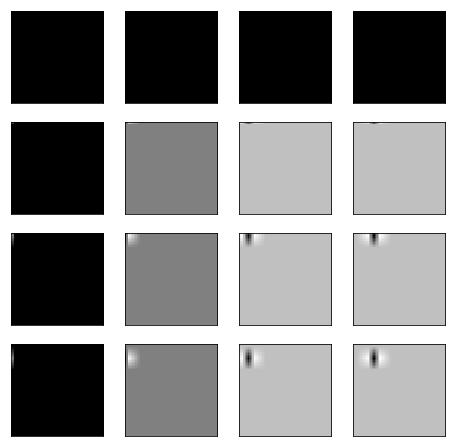

In [10]:
fig = plt.figure(figsize=(16, 16))

for i in range(4):
    for j in range(4):

        pixels = np.zeros((64, 64))
        coeffs = pywt.wavedec2(pixels, wavelet=wavelet_, level=3)
        coeffs[1][1][i, j] = 1.0
        recons = pywt.waverec2(coeffs, wavelet=wavelet_)
        max = recons.max()
        min = recons.min()
        if(max!=min):
            recons = (recons-min)/(max-min)*255
            
        plt.subplot(8, 8, 8*i+j+1)
        plt.imshow(recons, cmap=plt.cm.gray)
        plt.grid(False);
        plt.xticks([]);
        plt.yticks([]);

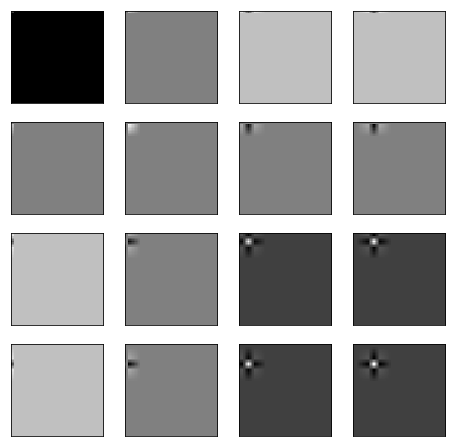

In [11]:
fig = plt.figure(figsize=(16, 16))

for i in range(4):
    for j in range(4):

        pixels = np.zeros((64, 64))
        coeffs = pywt.wavedec2(pixels, wavelet=wavelet_, level=3)
        coeffs[1][2][i, j] = 1.0
        recons = pywt.waverec2(coeffs, wavelet=wavelet_)
        max = recons.max()
        min = recons.min()
        if(max!=min):
            recons = (recons-min)/(max-min)*255
            
        plt.subplot(8, 8, 8*i+j+1)
        plt.imshow(recons, cmap=plt.cm.gray)
        plt.grid(False);
        plt.xticks([]);
        plt.yticks([]);

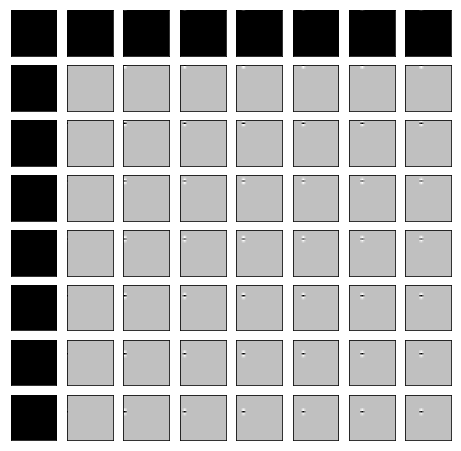

In [12]:
fig = plt.figure(figsize=(16, 16))

for i in range(8):
    for j in range(8):

        pixels = np.zeros((64, 64))
        coeffs = pywt.wavedec2(pixels, wavelet=wavelet_, level=3)
        coeffs[2][0][i, j] = 1.0
        recons = pywt.waverec2(coeffs, wavelet=wavelet_)
        max = recons.max()
        min = recons.min()
        if(max!=min):
            recons = (recons-min)/(max-min)*255
            
        plt.subplot(16, 16, 16*i+j+1)
        plt.imshow(recons, cmap=plt.cm.gray)
        plt.grid(False);
        plt.xticks([]);
        plt.yticks([]);

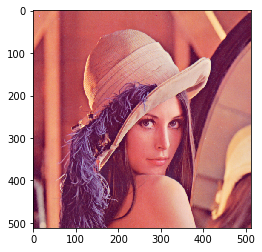

In [13]:
# Load lena

import urllib.request
from matplotlib import pyplot as plt
import numpy as np
import cv2 # pip install opencv-python

%matplotlib inline
HTTP_response = urllib.request.urlopen('http://www.hpca.ual.es/~vruiz/images/lena.png')
arr = np.asarray(bytearray(HTTP_response.read()), dtype=np.uint8)
BRG = cv2.imdecode(arr,-1)
pixels = cv2.cvtColor(BRG, cv2.COLOR_BGR2RGB)
plt.imshow(pixels)

In [16]:
# Color 2D-DWT is the 2D-DWT of each component
components = ('r','g','b')
coeffs = [None]*3
wavelet_= 'bior2.2'
levels_ = 5
for i,com in enumerate(components):
    print("{} ".format(i), end='')
    coeffs[i] = pywt.wavedec2(pixels[:,:,i], wavelet=wavelet_, level=levels_, mode='per')

0 1 2 

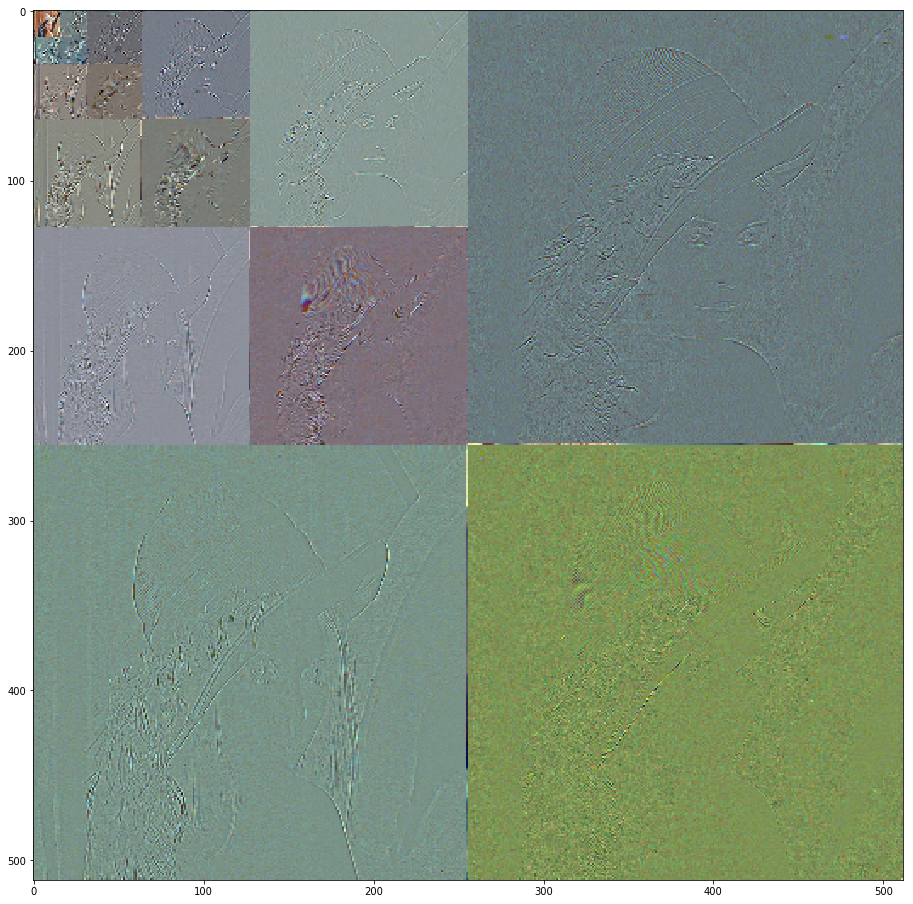

In [17]:
# View DWT coefs

fig = plt.figure(figsize=(16, 16))

view = np.empty(pixels.shape, 'uint8')

# LL subband
for i,com in enumerate(components):
    x = coeffs[i][0][:,:]
    y = ((x - x.min()) / (x.max() - x.min())*255).astype('uint8')
    view[0:coeffs[i][0].shape[0],
         0:coeffs[i][0].shape[1],
         i] = y

for l in range(levels_):

    # LH
    for i,com in enumerate(components):
        x = coeffs[i][l+1][0][:,:]
        y = ((x - x.min()) / (x.max() - x.min())*255).astype('uint8')
        view[0:coeffs[i][l+1][0].shape[0],
             coeffs[i][l+1][0].shape[1]:coeffs[i][l+1][0].shape[1]*2,
             i] = y

    # HH
    for i,com in enumerate(components):
        x = coeffs[i][l+1][1][:,:]
        y = ((x - x.min()) / (x.max() - x.min())*255).astype('uint8')
        view[coeffs[i][l+1][1].shape[0]:coeffs[i][l+1][1].shape[0]*2,
             0:coeffs[i][l+1][1].shape[1],
             i] = y

    # HH
    for i,com in enumerate(components):
        x = coeffs[i][l+1][2][:,:]
        y = ((x - x.min()) / (x.max() - x.min())*255).astype('uint8')
        view[coeffs[i][l+1][2].shape[0]:coeffs[i][l+1][2].shape[0]*2,
             coeffs[i][l+1][2].shape[1]:coeffs[i][l+1][2].shape[1]*2,
             i] = y

plt.subplot(1, 1, 1)
plt.imshow(view)

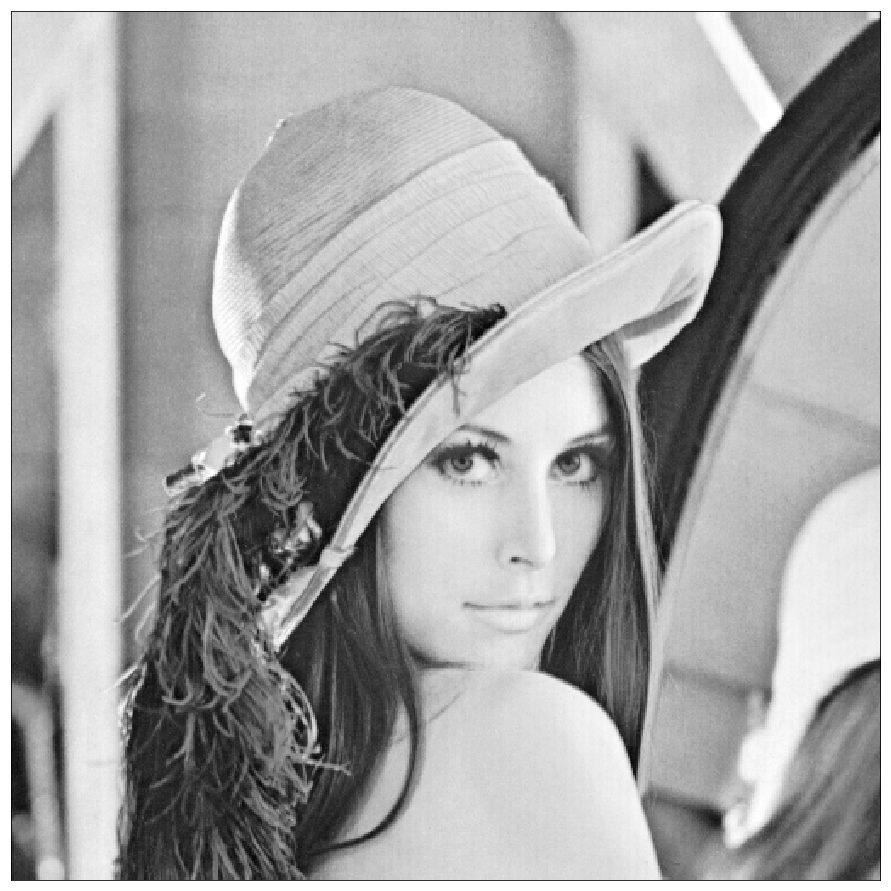

In [19]:
recons_ = pywt.waverec2(coeffs[0], wavelet=wavelet_, mode='per')
max = recons_.max()
min = recons_.min()
if(max!=min):
    recons = (recons_-min)/(max-min)*255

# Visualize
fig = plt.figure(figsize=(16, 16))

plt.imshow(recons, cmap=plt.cm.gray)
plt.grid(False);
plt.xticks([]);
plt.yticks([]);
plt.show()

255 0


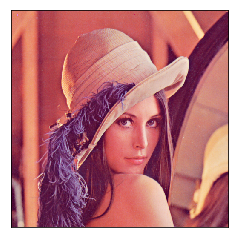

In [20]:
recons = np.empty(pixels.shape)

recons[:,:,0] = pywt.waverec2(coeffs[0], wavelet=wavelet_, mode='per')
recons[:,:,1] = pywt.waverec2(coeffs[1], wavelet=wavelet_, mode='per')
recons[:,:,2] = pywt.waverec2(coeffs[2], wavelet=wavelet_, mode='per')
max = recons.max()
min = recons.min()
if(max!=min):
    recons = ((recons-min)/(max-min)*255).astype('uint8')
                      
# Visualize
print(recons.max(), recons.min())
plt.imshow(recons)
plt.grid(False);
plt.xticks([]);
plt.yticks([]);
plt.show()

### Progressive transmission

100 coefficients

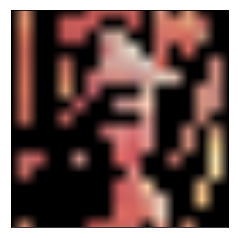

200 coefficients

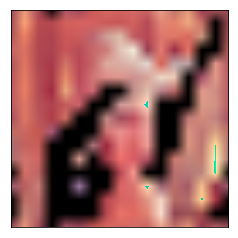

300 coefficients

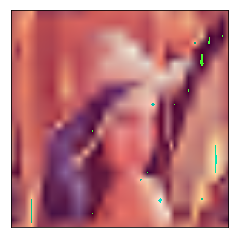

400 coefficients

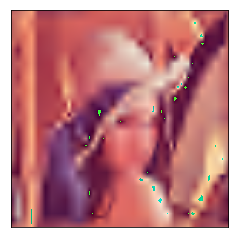

500 coefficients

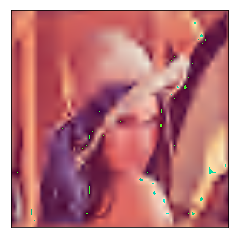

600 coefficients

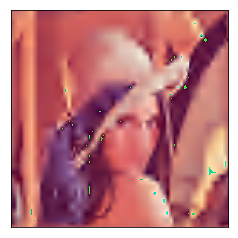

700 coefficients

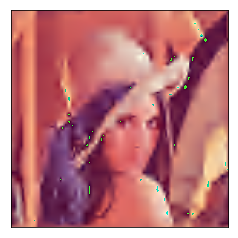

800 coefficients

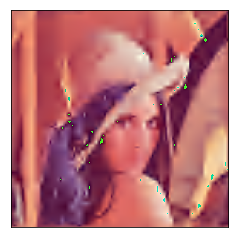

900 coefficients

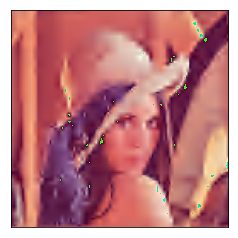

1000 coefficients

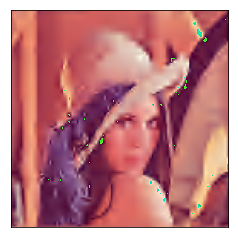

In [22]:
# Reconstruct with biggest DWT coefs
recons = np.empty(pixels.shape)

N = 100 # Step size (in coeffs) for each reconstruction
for k in range(10): # Up to 32 reconstructions

    coeffs_indexes = np.empty((pixels.shape[0] * pixels.shape[1]),
                            dtype='float, int, int, int, int')
                            # Coeff, level, subband, coor_x, coor_y

    # Process only the R component to find the higher coeffs
    
    offset = 0
    
    # LL
    for x in range(coeffs[0][0].shape[0]):
        for y in range(coeffs[0][0].shape[1]):
            coeffs_indexes[offset] = (np.abs(coeffs[0][0][x][y]), 0, 0, x, y)
            offset += 1
    
    # Rest of subbands
    for l in range(levels_):
        for s in range(3):
            for x in range(coeffs[0][l+1][s].shape[0]):
                for y in range(coeffs[0][l+1][s].shape[1]):
                    coeffs_indexes[offset] = (np.abs(coeffs[0][l+1][s][x][y]), (l+1), s, x, y)
                    offset += 1

    sorted = np.zeros((pixels.shape[0] * pixels.shape[1]), dtype='float, int, int, int, int')
    sorted = np.sort(coeffs_indexes)[::-1]

    # Reconstruct R

    # An "empty" transformed structure

    zeros = np.zeros((pixels.shape[0], pixels.shape[1]))
    filtered_coeffs = pywt.wavedec2(zeros, wavelet=wavelet_, level=levels_, mode='per')

    # Copy some coeffs
    for kk in range((k+1)*N):
        if sorted[kk][1] == 0:
            filtered_coeffs[0][sorted[kk][3], sorted[kk][4]] = \
            coeffs[0][0][sorted[kk][3], sorted[kk][4]]
        else:
            #print(kk, sorted[kk][1], sorted[kk][2], sorted[kk][3], sorted[kk][4])
            filtered_coeffs[sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]] = \
            coeffs[0][sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]]
        
    recons_ = pywt.waverec2(filtered_coeffs, wavelet=wavelet_, mode='per')
    recons[:,:,0] = recons_

    # Reconstruct G

    # An "empty" transformed structure

    zeros = np.zeros((pixels.shape[0], pixels.shape[1]))
    filtered_coeffs = pywt.wavedec2(zeros, wavelet=wavelet_, level=levels_, mode='per')

    # Copy some coeffs
    for kk in range((k+1)*N):
        if sorted[kk][1] == 0:
            filtered_coeffs[0][sorted[kk][3], sorted[kk][4]] = \
            coeffs[1][0][sorted[kk][3], sorted[kk][4]]
        else:
            filtered_coeffs[sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]] = \
            coeffs[1][sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]]
        
    recons_ = pywt.waverec2(filtered_coeffs, wavelet=wavelet_, mode='per')
    recons[:,:,1] = recons_
    
    # Reconstruct B

    # An "empty" transformed structure
    zeros = np.zeros((pixels.shape[0], pixels.shape[1]))
    filtered_coeffs = pywt.wavedec2(zeros, wavelet=wavelet_, level=levels_, mode='per')

    # Copy some coeffs
    for kk in range((k+1)*N):
        if sorted[kk][1] == 0:
            filtered_coeffs[0][sorted[kk][3], sorted[kk][4]] = \
            coeffs[2][0][sorted[kk][3], sorted[kk][4]]
        else:
            filtered_coeffs[sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]] = \
            coeffs[2][sorted[kk][1]][sorted[kk][2]][sorted[kk][3], sorted[kk][4]]

    recons_ = pywt.waverec2(filtered_coeffs, wavelet=wavelet_, mode='per')
    recons[:,:,2] = recons_
                      
    max = recons.max()
    min = recons.min()
    if(max!=min):
        recons = ((recons-min)/(max-min)*255).astype('uint8')

    # Visualize
    plt.imshow(recons)
    plt.grid(False);
    plt.xticks([]);
    plt.yticks([]);
    print("{} coefficients".format((k+1)*N), end='')
    plt.show()

## Bit-planes progression

<img src="00-fundamentals/bit-plane-trans.svg" style="width: 800px;"/>

## Code-stream ordering and scalability

The order in which the DWT coeﬃents are decoded determines the type of scalability (example with 2 qualities and 3 resolutions):

<img src="00-fundamentals/orderers-and-scalabilities.svg" style="width: 800px;"/>

In [ ]:
# http://www.degeneratestate.org/posts/2016/Oct/23/image-processing-with-numpy/
# http://www.scipy-lectures.org/packages/scikit-image/
# https://www.safaribooksonline.com/library/view/programming-computer-vision/9781449341916/ch01.html